In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import json
import re
import ast
import statsmodels.api as sm


In [138]:
%%capture
!pip install jsonpickle

In [291]:
def parse_log_file(file_path):
    
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Extract sections
    sandbox_section = re.search(r'Sandbox logs:(.*?)Activities log:', content, re.DOTALL).group(1).strip()
    activities_section = re.search(r'Activities log:(.*?)Trade History:', content, re.DOTALL).group(1).strip()
    trade_section = re.search(r'Trade History:(.*?)$', content, re.DOTALL).group(1).strip()
    
    # Function to parse multi-line JSON objects
    def extract_json_objects(json_string):
        # Split the string into lines
        lines = json_string.strip().split('\n')
        
        # Initialize variables
        json_objects = []
        current_object = ""
        inside_object = False
        
        for idx, line in enumerate(lines):
            if line.strip().startswith('{'):
                inside_object = True
                current_object = line
            elif line.strip().endswith('}') and inside_object:
                current_object += line
                json_objects.append(json.loads(current_object))
                current_object = ""
                inside_object = False
            elif inside_object:
                current_object += line
        
        return json_objects
    
    # Parse each section
    sandbox_logs = extract_json_objects(sandbox_section)
    activities_list = pd.read_csv(StringIO(activities_section), sep=';')
    trade_list = ast.literal_eval(trade_section)

    sandbox_dicts = {}
    
    own_trades_df = pd.DataFrame(columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])

    market_trades_df = pd.DataFrame(columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])
    
    bid_df = pd.DataFrame(columns=['symbol','bid_price', 'bid_volume','timestamp'])
    ask_df = pd.DataFrame(columns=['symbol','ask_price', 'ask_volume','timestamp'])

    position_df = pd.DataFrame(columns=['symbol', 'position', 'timestamp'])

    trader_orders_df = pd.DataFrame(columns=['timestamp', 'symbol', 'price', 'quantity', 'type'])
    trader_data_df = pd.DataFrame(columns=['timestamp', 'symbol', 'theos', 'past_log_returns', 'past_residuals', 'expected_return'])

    timestamps  = list(range(0, 1 + (len(sandbox_logs) * 1000), 1000))

    market_trade_info_df = pd.DataFrame(columns=['timestamp', 'symbol', 'average_weighted_price', 'total_volume'])


    for idx_log, log in enumerate(sandbox_logs):

        parsed = json.loads(log['lambdaLog'])
        sandbox_dicts[parsed['state']['timestamp']] = parsed

        parsed_own_trades_df = pd.DataFrame(parsed['state']["own_trades"], columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])

        if not parsed_own_trades_df.empty:
            own_trades_df = pd.concat([own_trades_df, parsed_own_trades_df], ignore_index=True)
            
        parsed_market_trades_df = pd.DataFrame(parsed['state']["market_trades"], columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])
        
        df_tuples = set(market_trades_df.astype(str).apply(tuple, axis=1))
        df_add_tuples = set(parsed_market_trades_df.astype(str).apply(tuple, axis=1))
        new_rows_tuples = df_add_tuples - df_tuples
        mask = parsed_market_trades_df.astype(str).apply(tuple, axis=1).isin(new_rows_tuples)
        new_rows = parsed_market_trades_df[mask]

        if not new_rows.empty:
            market_trades_df = pd.concat([market_trades_df, new_rows], ignore_index=True)
            
        for symbol, depth in parsed['state']['order_depths'].items():

            parsed_bid_df = pd.DataFrame(list(depth[0].items()), columns=['bid_price', 'bid_volume'])
            parsed_ask_df = pd.DataFrame(list(depth[1].items()), columns=['ask_price', 'ask_volume'])

            parsed_ask_df['ask_volume'] = np.abs(parsed_ask_df['ask_volume'])

            parsed_bid_df['symbol'] = symbol
            parsed_ask_df['symbol'] = symbol

            parsed_bid_df['timestamp'] = parsed['state']['timestamp']
            parsed_ask_df['timestamp'] = parsed['state']['timestamp']
            
            bid_df = pd.concat([bid_df, parsed_bid_df], ignore_index=True)
            ask_df = pd.concat([ask_df, parsed_ask_df], ignore_index=True)

        parsed_position_df = pd.DataFrame(list(parsed['state']['position'].items()), columns=['symbol', 'position'])

        parsed_position_df['timestamp'] = parsed['state']['timestamp']

        position_df = pd.concat([position_df, parsed_position_df], ignore_index=True)
        
        parsed_trader_data = json.loads(parsed['state']['trader_data'])

        orders_df = pd.DataFrame(columns = ['symbol', 'price', 'quantity', 'type', 'order_type','offset_asked'])

        past_info_df = pd.DataFrame({'symbol': list(parsed_trader_data['past_theos'].keys()), 'theos': [values[-1] for values in parsed_trader_data['past_theos'].values()],
                                        'past_log_returns': [values[-1] for values in parsed_trader_data['past_log_returns'].values()],
                                        'past_residuals': [values[-1] for values in parsed_trader_data['past_residuals'].values()],
                                        'expected_return': [values for values in parsed_trader_data['expected_return'].values()]
                                        })
        
        past_info_df['timestamp'] = parsed['state']['timestamp']

        market_trade_info_df = pd.concat([market_trade_info_df, pd.DataFrame({'timestamp': parsed['state']['timestamp'],
                                             'symbol': list(parsed_trader_data['market_trades_data'].keys()),
                                             'average_weighted_price': [values['average_weighted_price'] for values in parsed_trader_data['market_trades_data'].values()],
                                             'total_volume': [values['total_volume'] for values in parsed_trader_data['market_trades_data'].values()],
                                        })], ignore_index=True)

        for symbol in parsed_trader_data['last_maker_orders'].keys():
            maker_orders_df = pd.DataFrame(parsed_trader_data['last_maker_orders'][symbol], columns=['symbol', 'price', 'quantity','offset_asked']) if len(parsed_trader_data['last_maker_orders'][symbol]) > 0 else pd.DataFrame(columns=['symbol', 'price', 'quantity','offset_asked'])

            taker_orders_df = pd.DataFrame(parsed_trader_data['last_taker_orders'][symbol], columns=['symbol', 'price', 'quantity']) if len(parsed_trader_data['last_taker_orders'][symbol]) > 0 else pd.DataFrame(columns=['symbol', 'price', 'quantity'])

            maker_orders_df['type'] = 'maker'
            taker_orders_df['type'] = 'taker'
            taker_orders_df['offset_asked'] = np.nan


            dfs_to_concat = [df for df in [orders_df, maker_orders_df, taker_orders_df] if not df.empty]
            if dfs_to_concat: 
                orders_df = pd.concat(dfs_to_concat, ignore_index=True)


        orders_df['timestamp'] = parsed['state']['timestamp']
    
        if not past_info_df.empty:
            trader_data_df = pd.concat([trader_data_df, past_info_df], ignore_index=True)
        if not orders_df.empty:
            trader_orders_df = pd.concat([trader_orders_df, orders_df], ignore_index=True)

    trader_data_df = trader_data_df.groupby('symbol').apply(lambda x: x.assign(log_returns = x['past_log_returns'].shift(-1))).sort_values('timestamp').drop('past_log_returns', axis=1).reset_index(drop=True)

    own_trades_df = own_trades_df.drop_duplicates(subset=['symbol', 'timestamp'])

    market_trades_df = market_trades_df.sort_values('timestamp')
    
    symbols = position_df['symbol'].unique()

    result_dfs = []

    for symbol in symbols:
        symbol_data = position_df[position_df['symbol'] == symbol]

        symbol_all_times = pd.DataFrame({
                'symbol': symbol,
                'timestamp': timestamps
            })
        
        symbol_merged = pd.merge(symbol_all_times, symbol_data, 
                                    on=['symbol', 'timestamp'], how='left')
            
        symbol_merged = symbol_merged.sort_values('timestamp')
        symbol_merged['position'] = symbol_merged['position'].ffill().fillna(0).astype('float64')

        result_dfs.append(symbol_merged)

    position_df = pd.concat(result_dfs, ignore_index=True)

    return market_trade_info_df, trader_orders_df, trader_data_df, position_df, bid_df, ask_df, own_trades_df, market_trades_df,  pd.DataFrame(activities_list), pd.DataFrame(trade_list)


In [292]:
market_trade_info_df, trader_orders_df, trader_data_df, position_df, bid_df, ask_df, own_trades_df, market_trades_df,  activities_df, trade_history_df = parse_log_file("C://Users//marco//Downloads//a4ae8815-2895-4162-a44b-8a58799fe870.log")

C:\Users\marco\AppData\Local\Temp\ipykernel_21008\604159838.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trader_data_df = pd.concat([trader_data_df, past_info_df], ignore_index=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_21008\604159838.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  market_trades_df = pd.concat([market_trades_df, new_rows], ignore_index=True)
C:\Users\marco\AppData\Local\Temp\ipykernel_21008\604159838.py:114: FutureWarning: The behavior of DataFrame concaten

In [293]:
# Conversion for market_trade_info_df
market_trade_info_df['timestamp'] = market_trade_info_df['timestamp'].astype(int)
market_trade_info_df['symbol'] = market_trade_info_df['symbol'].astype(str)
market_trade_info_df['average_weighted_price'] = market_trade_info_df['average_weighted_price'].astype(float)
market_trade_info_df['total_volume'] = market_trade_info_df['total_volume'].astype(int)

# Conversion for trader_orders_df
trader_orders_df['timestamp'] = trader_orders_df['timestamp'].astype(int)
trader_orders_df['symbol'] = trader_orders_df['symbol'].astype(str)
trader_orders_df['price'] = trader_orders_df['price'].astype(int)
trader_orders_df['quantity'] = trader_orders_df['quantity'].astype(int)
trader_orders_df['type'] = trader_orders_df['type'].astype(str)
# offset_asked is already float64

# Conversion for trader_data_df
trader_data_df['timestamp'] = trader_data_df['timestamp'].astype(int)
trader_data_df['symbol'] = trader_data_df['symbol'].astype(str)
trader_data_df['past_theos'] = trader_data_df['past_theos'].astype(float)
# past_residuals, expected_return, theos, and log_returns are already float64

# Conversion for position_df
position_df['symbol'] = position_df['symbol'].astype(str)
position_df['timestamp'] = position_df['timestamp'].astype(int)
# position is already float64

# Conversion for bid_df
bid_df['symbol'] = bid_df['symbol'].astype(str)
bid_df['bid_price'] = bid_df['bid_price'].astype(int)
bid_df['bid_volume'] = bid_df['bid_volume'].astype(int)
bid_df['timestamp'] = bid_df['timestamp'].astype(int)

# Conversion for ask_df
ask_df['symbol'] = ask_df['symbol'].astype(str)
ask_df['ask_price'] = ask_df['ask_price'].astype(int)
ask_df['ask_volume'] = ask_df['ask_volume'].astype(int)
ask_df['timestamp'] = ask_df['timestamp'].astype(int)

# Conversion for own_trades_df
own_trades_df['symbol'] = own_trades_df['symbol'].astype(str)
# price is already float64
own_trades_df['quantity'] = own_trades_df['quantity'].astype(int)
own_trades_df['buyer'] = own_trades_df['buyer'].astype(str)
own_trades_df['seller'] = own_trades_df['seller'].astype(str)
own_trades_df['timestamp'] = own_trades_df['timestamp'].astype(int)

# Conversion for market_trades_df
market_trades_df['symbol'] = market_trades_df['symbol'].astype(str)
# price is already float64
market_trades_df['quantity'] = market_trades_df['quantity'].astype(int)
market_trades_df['buyer'] = market_trades_df['buyer'].astype(str)
market_trades_df['seller'] = market_trades_df['seller'].astype(str)
market_trades_df['timestamp'] = market_trades_df['timestamp'].astype(int)

# activities_df and trade_history_df appear to already have the correct types
# But we'll convert 'product' in activities_df to str and currency/buyer/seller in trade_history_df
activities_df['product'] = activities_df['product'].astype(str)

trade_history_df['buyer'] = trade_history_df['buyer'].astype(str)
trade_history_df['seller'] = trade_history_df['seller'].astype(str)
trade_history_df['symbol'] = trade_history_df['symbol'].astype(str)
trade_history_df['currency'] = trade_history_df['currency'].astype(str)

KeyError: 'past_theos'

### Description of All of the Dataframes

1.   market_trade_info_df: average weighted price, total_volume traded of market trades during timestamp
2.   trader_orders_df: price, quantity, type of order (maker or taker), and offset demanded if maker

        Explaining Offset Demanded:
        - If the trader is a maker, the offset demanded is (Edge of Order to Theo) / (Std of Price Return)

3.   trader_data_df: theo, last periods error, expected return, and log return.
4.   position_df: current position at timestamp t
5.   bid_df: bid price, volume
6.   ask_df: ask price, volume
7.   own_trades_df: filled trades with price, quantity, buyer, seller
8.   market_trades_df: market bot trades with price, quantity, buyer, seller
9.   activities_df: includes day, bids, mid_price, and our pnl
10.  trade_history_df: market_trades_df + own_trades_df

In [ ]:
# Filter maker orders
maker_orders = trader_orders_df[trader_orders_df['type'] == 'maker'].copy()

# Create separate masks for positive and negative quantity scenarios
buy_trades = own_trades_df[own_trades_df['buyer'] == 'SUBMISSION'].copy()
sell_trades = own_trades_df[own_trades_df['seller'] == 'SUBMISSION'].copy()

# Merge for positive quantity orders
buy_merged = maker_orders[maker_orders['quantity'] > 0].merge(
    buy_trades,
    on=['timestamp', 'price', 'symbol'],
    how='left',
    suffixes=('', '_trade')
)

# Merge for negative quantity orders
sell_merged = maker_orders[maker_orders['quantity'] < 0].merge(
    sell_trades,
    on=['timestamp', 'price', 'symbol'],
    how='left',
    suffixes=('', '_trade')
)

# Combine results
filled_orders = pd.concat([buy_merged, sell_merged])

# Group by the original index and sum the quantities
quantity_filled = filled_orders.groupby(filled_orders.index)['quantity_trade'].sum().fillna(0)

# Update the original dataframe
trader_orders_df['quantity_filled'] = 0
trader_orders_df.loc[quantity_filled.index, 'quantity_filled'] = quantity_filled

display(own_trades_df.head())
display(trader_orders_df.head())
# fill_probability

# 1 period edge

# 5 period edge

,symbol,price,quantity,buyer,seller,timestamp
0,RAINFOREST_RESIN,9999.0,10,SUBMISSION,,1100
7,KELP,2026.0,1,,SUBMISSION,1700
30,RAINFOREST_RESIN,9999.0,12,SUBMISSION,,2900
32,RAINFOREST_RESIN,10001.0,1,,SUBMISSION,3000
33,KELP,2026.0,1,,SUBMISSION,3000


,timestamp,symbol,price,quantity,type,offset_asked,quantity_filled
0,0,RAINFOREST_RESIN,10002,33,maker,3.333333,0
1,0,RAINFOREST_RESIN,10004,-50,maker,6.666667,0
2,0,RAINFOREST_RESIN,10001,17,maker,3.333333,0
3,0,KELP,2027,50,maker,5.156250,0
4,0,KELP,2029,-48,maker,4.843750,0


In [ ]:
for edge_retention_lag in edge_retention_lags:
trader_data_df['return_{edge_retention_lag}'] = trader_data_df.groupby('symbol').apply(lambda x: x['log_returns'].rolling(window=edge_retention_lag, min_periods=1).sum().shift(-edge_retention_lag+1)).reset_index(drop=True)

In [290]:
display(trader_data_df.head())

display(trader_orders_df.head())
edge_retention_lags = [1, 5]

for edge_retention_lag in edge_retention_lags:

    for each row in 
    trader_orders_df[f'edge_retention_lag_{edge_retention_lag}'] = trader_orders_df['offset_asked'].shift(-edge_retention_lag)

display(trader_orders_df.head())



Given trader_orders_df


,timestamp,symbol,past_theos,past_residuals,expected_return,theos,log_returns
0,0,KELP,NaN,0.000000,0.000000,2028.031250,-0.000129
1,0,RAINFOREST_RESIN,NaN,0.000000,0.000000,10002.666667,-0.000267
2,100,KELP,NaN,-0.000129,0.000200,2027.769231,-0.000591
3,100,RAINFOREST_RESIN,NaN,-0.000267,0.000078,10000.000000,0.000000
4,200,KELP,NaN,-0.000668,0.000159,2026.571429,0.000615


,timestamp,symbol,price,quantity,type,offset_asked
0,0,RAINFOREST_RESIN,10002,33,maker,3.333333
1,0,RAINFOREST_RESIN,10004,-50,maker,6.666667
2,0,RAINFOREST_RESIN,10001,17,maker,3.333333
3,0,KELP,2027,50,maker,5.156250
4,0,KELP,2029,-48,maker,4.843750


In [287]:
maker_orders_df = trader_orders_df[trader_orders_df['type'] == 'maker'].copy()

maker_orders_df['filled'] = maker_orders_df['quantity_filled'] != 0

X = np.log(maker_orders_df[['offset_asked']])
y = maker_orders_df['filled']

X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.120598
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 filled   No. Observations:                15799
Model:                          Logit   Df Residuals:                    15797
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:               3.643e-05
Time:                        09:52:41   Log-Likelihood:                -1905.3
converged:                       True   LL-Null:                       -1905.4
Covariance Type:            nonrobust   LLR p-value:                    0.7094
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.5896      0.102    -35.303      0.000      -3.789      -3.390
offset_asked    -0.0347

In [277]:
trader_orders_df[trader_orders_df['quantity_filled'] != 0].head()

,timestamp,symbol,price,quantity,type,offset_asked,quantity_filled
40,500,KELP,2025,6,maker,0.940433,10
69,900,KELP,2024,27,maker,2.753685,1
103,1300,KELP,2024,9,maker,0.913218,12
111,1400,KELP,2024,16,maker,1.619988,2
113,1500,RAINFOREST_RESIN,9999,40,maker,6.415858,2


In [267]:

display(trader_orders_df[trader_orders_df['quantity_filled'] == 0].head())

,timestamp,symbol,price,quantity,type,offset_asked,quantity_filled
0,0,RAINFOREST_RESIN,10002,33,maker,3.333333,0
1,0,RAINFOREST_RESIN,10004,-50,maker,6.666667,0
2,0,RAINFOREST_RESIN,10001,17,maker,3.333333,0
3,0,KELP,2027,50,maker,5.156250,0
4,0,KELP,2029,-48,maker,4.843750,0
...,...,...,...,...,...,...,...
95,1200,KELP,2028,-11,maker,1.144641,0
96,1300,RAINFOREST_RESIN,10000,30,maker,3.041535,0
97,1300,RAINFOREST_RESIN,10002,-60,maker,6.958465,0
98,1300,RAINFOREST_RESIN,9999,10,maker,3.216614,0


In [215]:
market_trades_df[market_trades_df['timestamp'] == 0].shape

(34, 6)

In [ ]:
symbol_mask = market_trade_info_df['symbol'] == 'RAINFOREST_RESIN'
symbol_mask = market_trade_info_df['symbol'] == 'KELP'
plt.plot(market_trade_info_df[symbol_mask]['timestamp'], market_trade_info_df[symbol_mask]['average_weighted_price'])
plt.show()

In [225]:
# display(trader_orders_df[trader_orders_df['type'] == 'taker'].head(50)) # MAKE SURE FROM SAME TIMESTAMP

# display(o_trades_df.head(10))

display(market_trades_df.head(50))

#, trader_orders_df, trader_data_df, position_df, bid_df, ask_df, own_trades_df, market_trades_df,  activities_df, trade_history_df 

,symbol,price,quantity,buyer,seller,timestamp
0,KELP,2029.0,13,,,0
19,KELP,2029.0,1,,,0
20,KELP,2029.0,13,,,0
21,KELP,2029.0,1,,,0
22,KELP,2029.0,13,,,0
23,KELP,2029.0,1,,,0
24,KELP,2029.0,13,,,0
18,KELP,2029.0,13,,,0
25,KELP,2029.0,1,,,0
28,KELP,2029.0,13,,,0


In [ ]:
display(activities_df.head()) 
display(bid_df.head())


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,31,NaN,NaN,NaN,NaN,2028.5,0.0
2,-1,100,KELP,2025,24,NaN,NaN,NaN,NaN,2028,2,2029.0,22.0,NaN,NaN,2026.5,0.0
3,-1,100,RAINFOREST_RESIN,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,0.0
4,-1,200,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,0.0


,symbol,bid_price,bid_volume,timestamp
0,KELP,2028,1,0
1,KELP,2026,2,0
2,KELP,2025,29,0
3,RAINFOREST_RESIN,10002,1,0
4,RAINFOREST_RESIN,9996,2,0


In [175]:
market_trades_df['timestamp'].values[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1700, 1700, 1700, 1700, 1700, 1700, 1700,
       1700, 1700, 1700, 1700, 1700, 1700, 1700, 1700, 1700, 1700, 1700,
       1700, 1700, 1700, 1700, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 3800, 3800], dtype=object)

In [167]:
display(own_trades_df.head(10))

display(market_trades_df[market_trades_df['timestamp'] == 1000].head(100))

,symbol,price,quantity,buyer,seller,timestamp
0,RAINFOREST_RESIN,9999.0,10,SUBMISSION,,1100
0,RAINFOREST_RESIN,9998.0,1,SUBMISSION,,1200
0,RAINFOREST_RESIN,10002.0,1,,SUBMISSION,1300
1,KELP,2025.0,9,,SUBMISSION,1700
0,RAINFOREST_RESIN,10002.0,1,,SUBMISSION,1800
0,RAINFOREST_RESIN,9998.0,1,SUBMISSION,,2000
1,KELP,2025.0,1,SUBMISSION,,2400
0,RAINFOREST_RESIN,9999.0,12,SUBMISSION,,2900
0,RAINFOREST_RESIN,9999.0,1,,SUBMISSION,3000
1,KELP,2026.0,1,,SUBMISSION,3000


,symbol,price,quantity,buyer,seller,timestamp


C:\Users\marco\AppData\Local\Temp\ipykernel_21008\1129176332.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  symbol_merged['position'] = symbol_merged['position'].ffill().fillna(0)
C:\Users\marco\AppData\Local\Temp\ipykernel_21008\1129176332.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  symbol_merged['position'] = symbol_merged['position'].ffill().fillna(0)


,symbol,timestamp,position
0,RAINFOREST_RESIN,0,0.0
1,RAINFOREST_RESIN,1000,0.0
2,RAINFOREST_RESIN,2000,-1.0
3,RAINFOREST_RESIN,3000,0.0
4,RAINFOREST_RESIN,4000,3.0
5,RAINFOREST_RESIN,5000,4.0
6,RAINFOREST_RESIN,6000,4.0
7,RAINFOREST_RESIN,7000,5.0
8,RAINFOREST_RESIN,8000,4.0
9,RAINFOREST_RESIN,9000,5.0


In [153]:
display(trader_orders_df.head(50))


,timestamp,symbol,price,quantity,type,order_type
0,400,RAINFOREST_RESIN,9998,25,maker,buy
0,400,RAINFOREST_RESIN,10001,-25,maker,sell
0,400,KELP,2025,25,maker,buy
0,400,KELP,2027,-25,maker,sell
0,500,RAINFOREST_RESIN,9999,25,maker,buy
0,500,RAINFOREST_RESIN,10002,-25,maker,sell
0,500,KELP,2025,25,maker,buy
0,500,KELP,2027,-25,maker,sell
0,600,RAINFOREST_RESIN,10000,25,maker,buy
0,600,RAINFOREST_RESIN,10001,-25,maker,sell


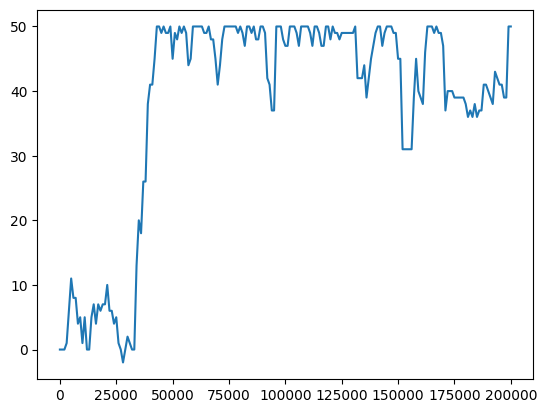

In [111]:
symbol_mask = position_df['symbol'] == 'RAINFOREST_RESIN'
symbol_mask = position_df['symbol'] == 'KELP'
plt.plot(position_df['timestamp'][symbol_mask], position_df['position'][symbol_mask])
plt.show()


In [146]:
display(trader_orders_df.head(10))

,timestamp,symbol,price,quantity,type,order_type
0,1200,RAINFOREST_RESIN,9998,1,taker,buy
0,1300,RAINFOREST_RESIN,10002,-1,taker,sell
0,1800,RAINFOREST_RESIN,10002,-1,taker,sell
0,2000,RAINFOREST_RESIN,9998,1,taker,buy
0,2400,KELP,2025,1,taker,buy
0,3100,KELP,2025,5,taker,buy
0,3600,RAINFOREST_RESIN,9998,4,taker,buy
0,3700,RAINFOREST_RESIN,10002,-1,taker,sell
0,4300,RAINFOREST_RESIN,9998,1,taker,buy
0,4300,KELP,2024,5,taker,buy


In [142]:
display(trader_orders_df.head(10))

display(own_trades_df.head(10))

print(own_trades_df.shape[0])
print(trader_data_df.shape[0])


,timestamp,symbol,price,quantity,type,order_type
0,1200,RAINFOREST_RESIN,9998,1,taker,buy
0,1300,RAINFOREST_RESIN,10002,-1,taker,sell
0,1800,RAINFOREST_RESIN,10002,-1,taker,sell
0,2000,RAINFOREST_RESIN,9998,1,taker,buy
0,2400,KELP,2025,1,taker,buy
0,3100,KELP,2025,5,taker,buy
0,3600,RAINFOREST_RESIN,9998,4,taker,buy
0,3700,RAINFOREST_RESIN,10002,-1,taker,sell
0,4300,RAINFOREST_RESIN,9998,1,taker,buy
0,4300,KELP,2024,5,taker,buy


,symbol,price,quantity,buyer,seller,timestamp
0,RAINFOREST_RESIN,9998.0,1,SUBMISSION,,1200
0,RAINFOREST_RESIN,10002.0,1,,SUBMISSION,1300
0,RAINFOREST_RESIN,10002.0,1,,SUBMISSION,1800
0,RAINFOREST_RESIN,9998.0,1,SUBMISSION,,2000
1,KELP,2025.0,1,SUBMISSION,,2400
1,KELP,2025.0,5,SUBMISSION,,3100
0,RAINFOREST_RESIN,9998.0,4,SUBMISSION,,3600
0,RAINFOREST_RESIN,10002.0,1,,SUBMISSION,3700
0,RAINFOREST_RESIN,9998.0,1,SUBMISSION,,4300
1,KELP,2024.0,5,SUBMISSION,,4300


562
4000


In [8]:
def weighted_midprice(df, levels=1, quantity_power = 1):
    def calculate_weighted_midprice(row, levels, quantity_power):
        bid_side = []
        ask_side = []
        
        for level in range(1, levels + 1):
            bid_price = row.get(f'bid_price_{level}', np.nan)
            bid_volume = row.get(f'bid_volume_{level}', np.nan) ** quantity_power
            ask_price = row.get(f'ask_price_{level}', np.nan)
            ask_volume = row.get(f'ask_volume_{level}', np.nan) ** quantity_power
            
            if np.isfinite(bid_price) and np.isfinite(bid_volume) and bid_volume > 0:
                bid_side.append((bid_price, bid_volume))
            if np.isfinite(ask_price) and np.isfinite(ask_volume) and ask_volume > 0:
                ask_side.append((ask_price, ask_volume))
        
        if not bid_side or not ask_side:
            return np.nan
        
        total_bid_weight = sum(volume for _, volume in bid_side)
        total_ask_weight = sum(volume for _, volume in ask_side)
        
        weighted_bid_price = sum(price * volume for price, volume in bid_side) / total_bid_weight if total_bid_weight > 0 else np.nan
        weighted_ask_price = sum(price * volume for price, volume in ask_side) / total_ask_weight if total_ask_weight > 0 else np.nan
        
        return (weighted_bid_price + weighted_ask_price) / 2 if np.isfinite(weighted_bid_price) and np.isfinite(weighted_ask_price) else np.nan
    
    return df.apply(lambda row: calculate_weighted_midprice(row, levels, quantity_power), axis=1)

df['weighted_midprice_level_1'] = weighted_midprice(df, levels=1, quantity_power = 1)
df['weighted_midprice_level_2'] = weighted_midprice(df, levels=2, quantity_power = 1)
df['weighted_midprice_level_3'] = weighted_midprice(df, levels=3, quantity_power = 1)

df['log_return_l1'] = df.groupby('product')['weighted_midprice_level_1'].transform(lambda x: np.log(x / x.shift()).fillna(0))
df['log_return_l2'] = df.groupby('product')['weighted_midprice_level_2'].transform(lambda x: np.log(x / x.shift()).fillna(0))
df['log_return_l3'] = df.groupby('product')['weighted_midprice_level_3'].transform(lambda x: np.log(x / x.shift()).fillna(0))

lags_realized_vol = [5, 10, 20]

for lag in lags_realized_vol:
    df[f'realized_vol_lag_{lag}'] = df.groupby('product')['log_return_l1'].transform(lambda x: x.pow(2).rolling(window=lag, min_periods=lag).mean().pow(0.5))

display(df.head())


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,profit_and_loss,weighted_midprice_level_1,weighted_midprice_level_2,weighted_midprice_level_3,log_return_l1,log_return_l2,log_return_l3,realized_vol_lag_5,realized_vol_lag_10,realized_vol_lag_20
0,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,...,0.0,10003.0,10001.467742,10000.108367,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,...,0.0,2028.5,2027.833333,2027.078125,0.000000,0.000000,0.000000,NaN,NaN,NaN
2,-1,100,KELP,2025,24,NaN,NaN,NaN,NaN,2028,...,0.0,2026.5,2026.958333,2026.958333,-0.000986,-0.000432,-0.000059,NaN,NaN,NaN
3,-1,100,RAINFOREST_RESIN,9996,2,9995.0,22.0,NaN,NaN,10004,...,0.0,10000.0,10000.000000,10000.000000,-0.000300,-0.000147,-0.000011,NaN,NaN,NaN
4,-1,200,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,...,0.0,10000.0,10000.000000,10000.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN


In [82]:
print(np.mean(rainforest_resin_df['weighted_midprice_level_1'].shift(1) < rainforest_resin_df['bid_price_1']))
print(np.mean(rainforest_resin_df['weighted_midprice_level_1'].shift(1) > rainforest_resin_df['ask_price_1']))

0.095
0.0855


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,profit_and_loss,weighted_midprice_level_1,weighted_midprice_level_2,weighted_midprice_level_3,log_return_l1,log_return_l2,log_return_l3,realized_vol_lag_5,realized_vol_lag_10,realized_vol_lag_20
0,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,...,0.0,10003.0,10001.467742,10000.108367,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,...,0.0,2028.5,2027.833333,2027.078125,0.000000,0.000000,0.000000,NaN,NaN,NaN
2,-1,100,KELP,2025,24,NaN,NaN,NaN,NaN,2028,...,0.0,2026.5,2026.958333,2026.958333,-0.000986,-0.000432,-0.000059,NaN,NaN,NaN
3,-1,100,RAINFOREST_RESIN,9996,2,9995.0,22.0,NaN,NaN,10004,...,0.0,10000.0,10000.000000,10000.000000,-0.000300,-0.000147,-0.000011,NaN,NaN,NaN
4,-1,200,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,...,0.0,10000.0,10000.000000,10000.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN


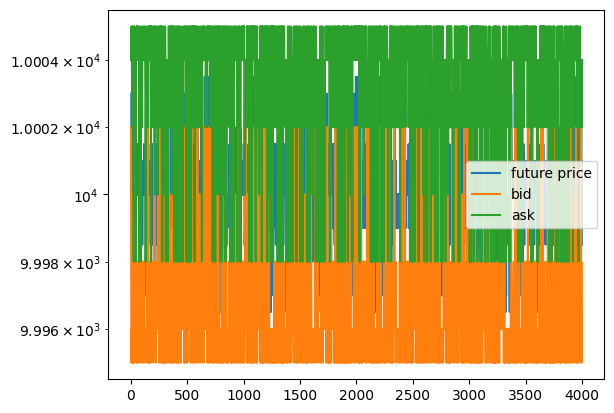

In [79]:
display(df.head())

rainforest_resin_df = df[df['product'] == 'RAINFOREST_RESIN']

plt.plot(rainforest_resin_df['weighted_midprice_level_1'].shift(1),label='future price')
plt.plot(rainforest_resin_df['bid_price_1'],label='bid')
plt.plot(rainforest_resin_df['ask_price_1'],label='ask')
plt.legend()


plt.show()


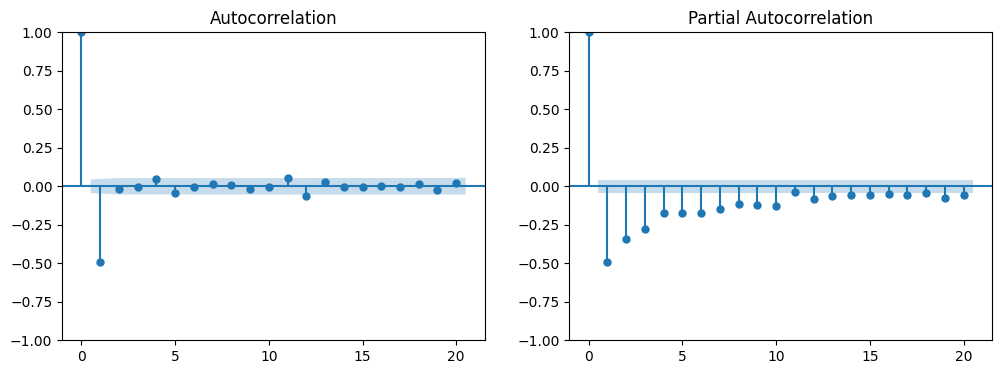

Product: RAINFOREST_RESIN


,Constant,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,R-squared,Alpha
LASSO,5.623049e-09,-0.930029,-0.875076,-0.803050,-0.696894,-0.643830,-0.559838,-0.446183,-0.330899,-0.233128,-0.124904,0.470093,1.291550e-08
RIDGE,5.113575e-09,-0.927789,-0.871235,-0.798151,-0.691477,-0.638435,-0.554766,-0.441721,-0.327388,-0.230759,-0.123715,0.470082,7.742637e-01
OLS,5.795221e-09,-0.930713,-0.876305,-0.804704,-0.698830,-0.645871,-0.561877,-0.448113,-0.332548,-0.234351,-0.125585,0.470094,0.000000e+00


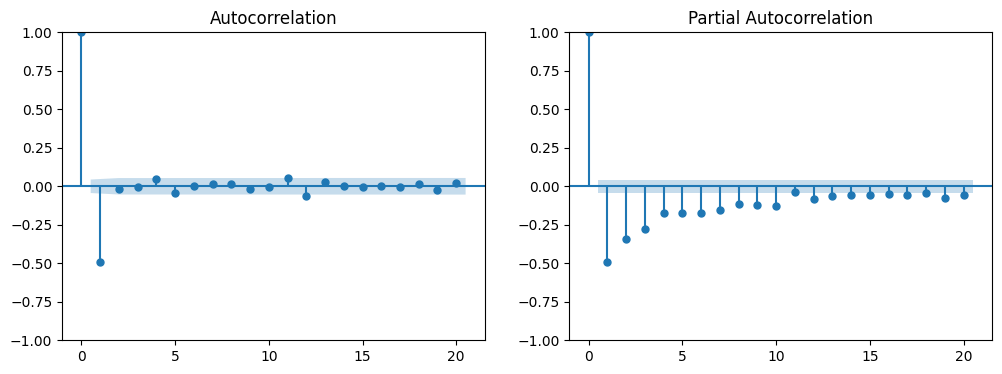

Product: KELP


,Constant,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,R-squared,Alpha
LASSO,-0.000003,-0.608853,-0.363231,-0.224237,-0.101506,-0.051231,-0.023897,0.004717,-0.005073,0.005143,-0.000000,0.278884,0.000001
RIDGE,-0.000003,-0.596634,-0.352916,-0.220101,-0.103575,-0.057420,-0.029780,0.004084,-0.007971,0.006968,-0.000430,0.278656,35.938137
OLS,-0.000003,-0.620009,-0.381059,-0.245287,-0.123107,-0.070816,-0.038314,-0.000726,-0.010228,0.006037,-0.000578,0.279242,0.000000


{'RAINFOREST_RESIN': array([ 5.62304929e-09, -9.30028753e-01, -8.75075778e-01, -8.03049707e-01,
       -6.96893912e-01, -6.43830189e-01, -5.59837861e-01, -4.46182551e-01,
       -3.30899270e-01, -2.33128278e-01, -1.24904479e-01]), 'KELP': array([-2.69462835e-06, -6.08853177e-01, -3.63230711e-01, -2.24236765e-01,
       -1.01506385e-01, -5.12305763e-02, -2.38972164e-02,  4.71738366e-03,
       -5.07273247e-03,  5.14326552e-03, -0.00000000e+00])}
{'RAINFOREST_RESIN': 0.6856335205829088, 'KELP': 0.5280943743162441}


In [134]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler


def har_all_features(X, lags, window_y=1):
    df = pd.DataFrame(X.T)
    
    # Calculate lag features (unchanged from your original code)
    lag_features = np.zeros((df.shape[0], len(lags) * df.shape[1]))
    for i, lag in enumerate(lags):
        start_ind = i * df.shape[1]
        end_ind = (i + 1) * df.shape[1]
        if i == 0:
            lag_features[:, start_ind : end_ind] = df.rolling(lag).mean().shift(1).to_numpy()
        else:
            prev_lag = lags[i-1]  # Previous lag boundary
            lag_features[:, start_ind:end_ind] = (
                df.rolling(lag).sum().shift(1).to_numpy() - df.rolling(prev_lag).sum().shift(1).to_numpy()
            ) / (lag - prev_lag)
    
    # For features_y, calculate forward-looking averages
    features_y = np.zeros_like(df.values)
    for i in range(len(df) - window_y + 1):
        # For each eligible row, compute average of current and next window_y-1 values
        features_y[i] = df.iloc[i:i+window_y].mean().values
    
    # Set valid range accounting for both lags and forward window
    start_idx = max(lags)
    end_idx = len(df) - window_y + 1
    
    # Return only the valid range
    return lag_features[start_idx:end_idx], features_y[start_idx:end_idx]



def har_all_features_var(X, lags, window_y=1):
    df = pd.DataFrame(X.T)
    
    # Calculate lag features (unchanged from your original code)
    lag_features = np.zeros((df.shape[0], len(lags) * df.shape[1]))
    for i, lag in enumerate(lags):
        start_ind = i * df.shape[1]
        end_ind = (i + 1) * df.shape[1]
        if i == 0:
            lag_features[:, start_ind : end_ind] = df.pow(2).rolling(lag).mean().shift(1).to_numpy()
        else:
            prev_lag = lags[i-1]  # Previous lag boundary
            lag_features[:, start_ind:end_ind] = (
                df.pow(2).rolling(lag).sum().shift(1).to_numpy() - df.pow(2).rolling(prev_lag).sum().shift(1).to_numpy()
            ) / (lag - prev_lag)
    
    # For features_y, calculate forward-looking averages
    features_y = np.zeros_like(df.values)
    for i in range(len(df) - window_y + 1):
        # For each eligible row, compute average of current and next window_y-1 values
        features_y[i] = df.iloc[i:i+window_y].pow(2).mean().values
    
    # Set valid range accounting for both lags and forward window
    start_idx = max(lags)
    end_idx = len(df) - window_y + 1
    
    # Return only the valid range
    return lag_features[start_idx:end_idx], features_y[start_idx:end_idx]


betas = {}

signal_return_correlation = {}

n_cv = 5


for product in df['product'].unique():

     
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(y, ax=axes[0], lags=20)
    plot_pacf(y, ax=axes[1], lags=20)
    plt.show()

    pacf_vals, confint = pacf(y, nlags=20, alpha=0.05)

    # Loop over lags starting at 1 (lag 0 is always 1)
    significant_lags = []
    for lag in range(1, len(pacf_vals)):
        lower, upper = confint[lag]
        # If the PACF value is outside the confidence interval, it's significant
        if np.sign(lower) == np.sign(upper):
            significant_lags.append(lag)
        else:
            # Stop at the first non-significant lag
            break

    X, y = har_all_features(df[df['product'] == product]['log_return_l1'], lags=significant_lags, window_y=1)

    y = y.ravel()

    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    X_mean = scaler.mean_
    X_std = scaler.scale_

    ridge = RidgeCV(cv=n_cv, alphas=np.logspace(-8, 3, 100)).fit(X_scaled, y)
    lasso = LassoCV(cv=n_cv, alphas=np.logspace(-8, 3, 100)).fit(X_scaled, y)
    ols = sm.OLS(y, sm.add_constant(X_scaled)).fit()

    best_alpha_ridge = ridge.alpha_
    best_alpha_lasso = lasso.alpha_

    r_squared_lasso = lasso.score(X_scaled, y)
    r_squared_ridge = ridge.score(X_scaled, y)
    r_squared_ols = ols.rsquared

    # Get scaled coefficients
    lasso_coef_scaled = lasso.coef_
    ridge_coef_scaled = ridge.coef_

    # Rescale coefficients to original scale
    lasso_coef_original = lasso_coef_scaled / X_std  # Rescale slopes
    ridge_coef_original = ridge_coef_scaled / X_std

    # Adjust intercept for original scale
    lasso_intercept_original = lasso.intercept_ - np.sum(lasso_coef_scaled * X_mean / X_std)
    ridge_intercept_original = ridge.intercept_ - np.sum(ridge_coef_scaled * X_mean / X_std)

    # Extract scaled OLS coefficients
    ols_intercept_scaled = ols.params[0]
    ols_coef_scaled = ols.params[1:]

    # Rescale OLS coefficients
    ols_coef_original = ols_coef_scaled / X_std  # Rescale slopes
    ols_intercept_original = ols_intercept_scaled - np.sum(ols_coef_scaled * X_mean / X_std)
    
    # Combine intercept and rescaled coefficients
    coef_names = ['Constant'] + [f'Lag_{lag}' for lag in significant_lags]

    # Select model type
    ridge_coef_values = np.hstack(([ridge_intercept_original], ridge_coef_original))
    lasso_coef_values = np.hstack(([lasso_intercept_original], lasso_coef_original))
    ols_coef_values = np.hstack(([ols_intercept_original], ols_coef_original))
    
    # Print summary

    coef_values = np.vstack((lasso_coef_values, 
               ridge_coef_values, 
               ols_coef_values))
    
    r2_values = np.array([r_squared_lasso, r_squared_ridge, r_squared_ols]).reshape(3, 1)
    best_alpha_values = np.array([best_alpha_lasso, best_alpha_ridge, 0]).reshape(3, 1)

    regression_df = pd.DataFrame(np.hstack((coef_values, r2_values, best_alpha_values)))
    regression_df.columns = coef_names + ['R-squared'] + ['Alpha']
    regression_df.index = ['LASSO', 'RIDGE', 'OLS']
            

    print(f"Product: {product}")
    display(regression_df)

    if r_squared_lasso > r_squared_ridge:
        betas[product] = lasso_coef_values
        signal_return_correlation[product] = r_squared_lasso ** 0.5
    else:
        betas[product] = ridge_coef_values
        signal_return_correlation[product] = r_squared_ridge ** 0.5

print(betas)
print(signal_return_correlation)


In [44]:
!pip install pmdarima

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   --------------------------------------- 614.7/614.7 kB 11.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------------------ --------- 2.1/2.8 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 10.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: C:\Users\marco\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [66]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

def ewma_variance(returns, alpha, init_period=10):

    ewma_var = np.zeros_like(returns)
    for t in range(1, len(returns)):
        ewma_var[t] = (1 - alpha) * ewma_var[t-1] + alpha * returns[t-1]**2  # Lagged variance update
    return ewma_var

init_period = 10
alphas_ewma = [0.9, 0.95, 0.96, 0.97, 0.98, 0.99]

for product in df['product'].unique():
    y = df[df['product'] == product]['log_return_l1'].values

    future_variance = y[init_period:] ** 2

    ewma_predictors = np.zeros((len(future_variance), len(alphas_ewma)))
    for i, alpha_ewma in enumerate(alphas_ewma):
        ewma_var = ewma_variance(y, alpha_ewma)
        predictor = ewma_var[init_period-1:-1]  # Predict variance using previous EWMA (X)
        ewma_predictors[:, i] = predictor

    # Add constant term for intercept
    X = ewma_predictors

    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    X_mean = scaler.mean_
    X_std = scaler.scale_

    # Fit Lasso with cross-validation to find the best alpha
    lasso = LassoCV(cv=5, alphas=np.logspace(-4, 2, 100), max_iter=10000).fit(X, future_variance)

    # Get R-squared
    r_squared = lasso.score(X, future_variance)

    coef_scaled = lasso.coef_  # LASSO coefficients (for standardized X)
    intercept_scaled = lasso.intercept_

    # Rescale non-constant coefficients
    coef_original = coef_scaled / X_std  # Rescale slopes
    intercept_original = intercept_scaled - np.sum(coef_scaled * X_mean / X_std)  # Adjust intercept

    # Combine intercept and rescaled coefficients
    coef_names = ['Constant'] + [f'Alpha_{alpha_ewma}' for alpha_ewma in alphas_ewma]
    coef_values = np.hstack(([intercept_original], coef_original))

    # Print summary
    coef_df = pd.DataFrame({'Coefficient': coef_names, 'Value': coef_values})
    print(f"Product: {product}")
    print(coef_df.to_string(index=False))
    print(f"R-squared: {r_squared:.4f}\n")



Product: RAINFOREST_RESIN
Coefficient         Value
   Constant  4.427334e-08
  Alpha_0.9 -0.000000e+00
 Alpha_0.95 -0.000000e+00
 Alpha_0.96 -0.000000e+00
 Alpha_0.97 -0.000000e+00
 Alpha_0.98 -0.000000e+00
 Alpha_0.99 -0.000000e+00
R-squared: 0.0000

Product: KELP
Coefficient        Value
   Constant 1.489797e-07
  Alpha_0.9 0.000000e+00
 Alpha_0.95 0.000000e+00
 Alpha_0.96 0.000000e+00
 Alpha_0.97 0.000000e+00
 Alpha_0.98 0.000000e+00
 Alpha_0.99 0.000000e+00
R-squared: 0.0000



In [129]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs

arima_betas = {}
arima_signal_return_correlation = {}
for product in df['product'].unique():

    X, y = har_all_features(df[df['product'] == product]['log_return_l1'], lags=[i for i in range(1, 2)], window_y=1)

    model1 = ARIMA(y, order=(1, 0, 1))
    result1 = model1.fit()
    print(result1.summary())
    # After fitting your model
    y_pred = result1.predict()
    y_mean = y.mean()
    ss_total = sum((y - y_mean) ** 2)
    ss_residual = sum(result1.resid ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    print(f"R-squared: {r_squared}")


    ar_params = np.array(result1.arparams)
    ma_params = np.array(result1.maparams)

    arima_betas[product] = (ar_params, ma_params)
    
    arima_signal_return_correlation[product] = r_squared ** 0.5

print(arima_betas)
print(arima_signal_return_correlation)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1999
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14659.556
Date:                Mon, 10 Mar 2025   AIC                         -29311.112
Time:                        16:14:02   BIC                         -29288.711
Sample:                             0   HQIC                        -29302.887
                               - 1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.597e-06   8.24e-07     -1.939      0.053   -3.21e-06    1.76e-08
ar.L1          0.0422      0.011      3.996      0.000       0.022       0.063
ma.L1         -0.7940      0.013    -60.689      0.0

C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Calculate historical vol
- Add theo columnm which is the true mid price using weighted average using tightest spread and quantity fraction
- Add rolling average of mid prices (window_size=5)
- Add a vol column where we calculate vol based on last 5 entries

In [135]:
import json
import jsonpickle

# Path to your log file
log_file_path = "path/to/your/logfile.log"

# Read the entire content of the log file.
with open(log_file_path, "r") as f:
    log_content = f.read().strip()

# Parse the JSON string from the log file.
data = json.loads(log_content)

# Verify that data is a list with 5 elements.
if not (isinstance(data, list) and len(data) == 5):
    raise ValueError("Log file content is not in the expected format.")

# Unpack the five items.
compressed_state, compressed_orders, conversions, trader_data_str, logger_logs = data

timestamp = compressed_state[0]              # int: the timestamp
state_trader_data = compressed_state[1]        # str: the (truncated) traderData stored in the state
listings = compressed_state[2]                 # list of listings, each a list: [symbol, product, denomination]
order_depths = compressed_state[3]             # dict: {symbol: [buy_orders, sell_orders]}
own_trades = compressed_state[4]               # list of trades, each trade is a list: [symbol, price, quantity, buyer, seller, timestamp]
market_trades = compressed_state[5]            # list of trades, same format as own_trades
position = compressed_state[6]                 # dict: current positions by product
observations = compressed_state[7]             # list: [plainValueObservations, conversionObservations]

# print("Timestamp:", timestamp)

print("Listings:")
for listing in listings:
    # Each listing is [symbol, product, denomination]
    print("  Symbol:", listing[0], "Product:", listing[1], "Denom:", listing[2])

# The compressed orders is a list of orders (each order is [symbol, price, quantity])
# print("Compressed Orders:")
# for order in compressed_orders:
#     print("  Order:", order)

# Conversions is just an integer.
print("Conversions:", conversions)

# The trader data (if encoded via jsonpickle) can be decoded if needed.
# try:
#     decoded_trader_data = jsonpickle.decode(trader_data_str)
#     print("Decoded Trader Data:", decoded_trader_data)
# except Exception as e:
#     print("Trader Data could not be decoded. Raw data:", trader_data_str)

# The logger logs is a simple string.
print("Logger Logs:")
print(logger_logs)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(RAINFOREST_RESIN, 9998, 1)]


ValueError: malformed node or string on line 1: <ast.Name object at 0x000001AE8088B5E0>

In [ ]:
print(log_df[log_df['Symbol'] == 'KELP']['MakerOrders'].value_counts())
print(log_df[log_df['Symbol'] == 'RAINFOREST_RESIN']['MakerOrders'].value_counts())

,Timestamp,Symbol,ExpectedReturn,RealizedReturn,MakerFillPercentage,TakerFillPercentage
1,0,RAINFOREST_RESIN,NaN,0.000000,0.0,0.0
3,100,RAINFOREST_RESIN,0.000000,-0.000267,0.0,0.0
5,200,RAINFOREST_RESIN,0.000132,0.000000,0.0,0.0
7,300,RAINFOREST_RESIN,0.000069,0.000000,0.0,0.0
9,400,RAINFOREST_RESIN,0.000036,0.000000,0.0,0.0


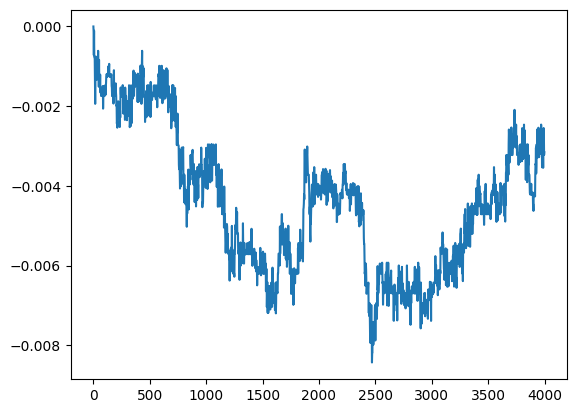

In [68]:
plt.plot(log_df[log_df['Symbol'] == 'KELP']['RealizedReturn'].cumsum())

                                 OLS Regression Results                                
Dep. Variable:         RealizedReturn   R-squared (uncentered):                   0.385
Model:                            OLS   Adj. R-squared (uncentered):              0.385
Method:                 Least Squares   F-statistic:                              1251.
Date:                Mon, 10 Mar 2025   Prob (F-statistic):                   3.18e-213
Time:                        13:03:34   Log-Likelihood:                          14370.
No. Observations:                2000   AIC:                                 -2.874e+04
Df Residuals:                    1999   BIC:                                 -2.873e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

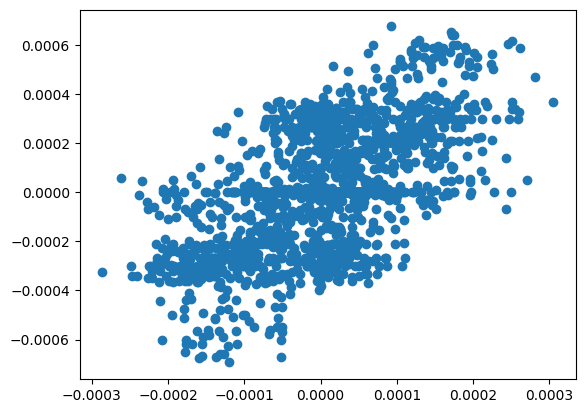

In [26]:

symbol_mask = log_df['Symbol'] == 'RAINFOREST_RESIN'


model = sm.OLS(log_df[symbol_mask]['RealizedReturn'], log_df[symbol_mask]['ExpectedReturn'])
result = model.fit()
print(result.summary())

plt.scatter(log_df[symbol_mask]['ExpectedReturn'], log_df[symbol_mask]['RealizedReturn'])

plt.show()



In [27]:
np.corrcoef(log_df[log_df['Symbol'] == 'KELP']['RealizedReturn'], log_df[log_df['Symbol'] == 'RAINFOREST_RESIN']['RealizedReturn'])

array([[ 1.        , -0.00415965],
       [-0.00415965,  1.        ]])

### Forced Trades

### Summary of PNL Per Product / Strategy

### Multiple Theos - Effect of Bid-Ask Bounce

### Execution Probability of Maker Orders Given Width

### Volatility Regression

### Fill Probabilty / Edge Retention By Order Level Sent

### Forecasting Future Price Given Fills And Past Returns

### Lead / Lag Relationships

### Cross-Product Correlations

### Multi-Period Forecasting